#HW6: Variational Autoencoder
In this homework, we will explore how to develop a Variational Autoencoder (VAE). As a dataset, we will use the MNIST dataset.
In developing the VAE, we also explore how to develop an ad-hoc layer and a nonstandard training step.


##Load data
We load the MNIST dataset, using tf.keras.datasets. We will use the same code used in HW5

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras as ker
import matplotlib.pyplot as plt
import tensorflow.keras.backend as back 

In [2]:
(x_train, y_train), (x_test, y_test) = ker.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000], y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

11493376/11490434 [==============================] - 0s 0us/step


##Exercise 6.1: Variational Autoencoder and the reparameterization trick
The reparameterization trick is an important component of VAE. It allows to implement the sampling phase, while keeping the network trainable via gradient ascent/descent.
Keras does not provide any predefined method to perform this operation, therefore we have to define it. With the aim to be consistent with the layer-composition paradigm used by Keras in defining a model, we define the sample layer as a new layer.

To do this we define a new class that inherits from the layer base class tf.keras.layers that is used as base class for all the layers defined in Keras. In particular, from this class we are interested in overriding the call method, that is the one that is called when a layer is exploited by the model, and where the operations executed by the layer are defined.

In our case, the new Sampling layer has in input a mean vector $z_{\mu}$ and a ``variance'' vector $z_{\sigma}$, and it has to compute a sample $z$ from them by exploiting the reparameterization trick:
$$
z=z_{\mu} + exp(z_{\sigma}) \odot \epsilon,
$$
where $\epsilon$ is sampled by a normal distribution with zero mean and identity covariance matrix. 

**To complete: complete the code defining the Sampling layer that implements the reparameterization trick**

**Hint: to generate a random value from a normal distribution keras provides the [tf.keras.backend.random_normal](https://www.tensorflow.org/api_docs/python/tf/keras/backend/random_normal) method.**

**In addition to that, explain why in the reparameterization formula it makes sense to use $exp(z_{\sigma})$ instead of directly using $z_{\sigma}$.**

Here, we have to use the exponential of the variance in input, because it is the logarithm of the variance, which many times is a small number, and by using the exponential, we can have it to become a number in a wider range of values also to avoid issues like problems with computer number representation. 

In [3]:
initial_dim = 784
b_s = 128

In [4]:
class Sampling(tf.keras.layers.Layer):
   
    def call(self, inputs):
        mu, log_sigma = inputs
        eps = back.random_normal(shape=(tf.shape(log_sigma)), mean=0., stddev=1.)
        return tf.add(mu, tf.multiply(tf.exp(log_sigma / 2), eps))

        #To complete: compute and return z

##Exercise 6.2: Encoder
Now we can define the encoder. Let's use 3 dense layers (similarly to what we did in HW4), and then use the obtained encoding to compute $z_{\mu}$ and $z_\sigma$, by using two different dense layers. Finally, we use the Sampling layer to compute the sample $z$. 

In order to allow the exploration of the latent space, we will stick on a latent space of size $2$ (that is, the dimension of $z$ should be $2$).

**To complete: complete the code defining a deep encoder and the Dense layers that model $z_{\mu}$ and $z_\sigma$. Justify in this cell your choice for what concerns the layers sizes and the activation functions** 

Here i chose to use the ReLU activation function, because it led to a more stable train of the network, since other function resulted to have more vanishing problems.
Then i decided to use this size numbers, because, after i have tried some combinations, this seems to be the better. 


In [39]:
latent_dim = 2
ENCODING_DIM = [500, 200] #136.3375
ENCODING_DIM = [500, 200, 50] # sigmoid 154.5063
ENCODING_DIM = [200] # 148.1035
ENCODING_DIM = [500, 200, 10] # 135.7573
ENCODING_DIM = [500, 200, 50] # 134.0811 
encoder_inputs = ker.layers.Input(shape=(initial_dim,))
encoded = encoder_inputs
for i in ENCODING_DIM:
    encoded = ker.layers.Dense(i, activation='relu')(encoded)

z_mean =  ker.layers.Dense(latent_dim, activation='linear')(encoded)#To complete: size would be = latent_dim
z_var =  ker.layers.Dense(latent_dim, activation='linear')(encoded)#To complete: size would be = latent_dim

z = Sampling()([z_mean, z_var])
encoder = ker.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_48 (Dense)                (None, 500)          392500      input_13[0][0]                   
__________________________________________________________________________________________________
dense_49 (Dense)                (None, 200)          100200      dense_48[0][0]                   
__________________________________________________________________________________________________
dense_50 (Dense)                (None, 50)           10050       dense_49[0][0]                   
____________________________________________________________________________________________

##Exercise 6.3: Decoder
Then we have to define the decoder part. It has in input $z$ and returns its "decoding". Its topology will have a ``mirror'' shape w.r.t. the encoder. 

**To complete: define the decoder. Explain in this cell your choice for what concerns the number of layers, the layers sizes and the activation functions (in particular for what concerns the last layer)**

The layers in the decoder is strictly connected to the ones of the encoder, so i used the same numbers mirrored with same activation function. I only changed the last activation function, since the sigmoid outputs values in range [0, 1] as our values are.

In [40]:
latent_inputs = ker.layers.Input(shape=(latent_dim,))

decoded = latent_inputs
ENCODING_DIM.reverse()
for i in ENCODING_DIM:
    decoded = ker.layers.Dense(i, activation='relu')(decoded)
decoder_outputs = ker.layers.Dense(initial_dim, activation='sigmoid')(decoded)

decoder = ker.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_53 (Dense)             (None, 50)                150       
_________________________________________________________________
dense_54 (Dense)             (None, 200)               10200     
_________________________________________________________________
dense_55 (Dense)             (None, 500)               100500    
_________________________________________________________________
dense_56 (Dense)             (None, 784)               392784    
Total params: 503,634
Trainable params: 503,634
Non-trainable params: 0
_________________________________________________________________


##Exercise 6.4: Training
Now we can define the VAE, but since it is a generative model, we have to define an ad hoc training phase. In particular, we have to manage the two losses used for this model. Indeed the parameters of a VAE are trained via two loss functions: a reconstruction loss that forces the decoded samples to match the original inputs, and a regularization loss that helps to learn well-formed latent spaces (Gaussian prior) and reduces overfitting to the training data. The regularization loss involves the Kullback-Liebler Divergence. While for the reconstruction loss we are supposed to use the negative log-likelihood. Keras, however, does not support it natively, so to make the exercise simple, we will use as a proxy the binary cross-entropy to compare each feature of a data point to the value in the reconstructed output.

Therefore, we have to define a class that inherits from [keras.model](https://www.tensorflow.org/api_docs/python/tf/keras/Model), and overrides the [training_step method](https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_step), that allows to define a custom training logic.

**To complete: implement the reconstruction loss and KL-loss (look at the VAE paper in Moodle)**

In [41]:
class VAE(ker.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            reconstruction_loss = tf.reduce_mean(ker.losses.binary_crossentropy(data, reconstruction)) * initial_dim 
            kl_loss = -0.5 * tf.reduce_mean(1 + z_var - tf.exp(z_var) - back.square(z_mean))

            #reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(data,reconstruction)) * 784
            #kl_loss = -0.5 * tf.reduce_mean(1+ z_var - tf.keras.backend.square(z_mean) - tf.exp(z_var))

            total_loss = reconstruction_loss + kl_loss
            grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

Let's now train the VAE model using Adam as optimizer

In [42]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=ker.optimizers.Adam(learning_rate=0.001))
vae.fit(x_train, epochs=30, batch_size=b_s)

Epoch 1/30
391/391 [==============================] - 10s 26ms/step - loss: 189.7167 - reconstruction_loss: 186.3802 - kl_loss: 3.3365
Epoch 2/30
391/391 [==============================] - 10s 25ms/step - loss: 162.9972 - reconstruction_loss: 160.0619 - kl_loss: 2.9353
Epoch 3/30
391/391 [==============================] - 10s 26ms/step - loss: 155.9615 - reconstruction_loss: 152.7663 - kl_loss: 3.1952
Epoch 4/30
391/391 [==============================] - 10s 26ms/step - loss: 150.9569 - reconstruction_loss: 147.5582 - kl_loss: 3.3987
Epoch 5/30
391/391 [==============================] - 10s 25ms/step - loss: 147.8825 - reconstruction_loss: 144.4027 - kl_loss: 3.4798
Epoch 6/30
391/391 [==============================] - 10s 25ms/step - loss: 145.8984 - reconstruction_loss: 142.3767 - kl_loss: 3.5217
Epoch 7/30
391/391 [==============================] - 10s 25ms/step - loss: 144.2171 - reconstruction_loss: 140.6624 - kl_loss: 3.5547
Epoch 8/30
391/391 [==============================] - 1

##Exercise 6.5: Model Analysis
We can now plot an example of the data generation by using the decoder part. Since we used a 2D latent space let's generate several  2D $\hat{z}$ samples and pass them to our decoder. The interval where to sample  $\hat{z}$ can be controlled by the $scale$ parameter, while the number of generated samples is controlled by the $n$ parameter.


Output with scale 2:


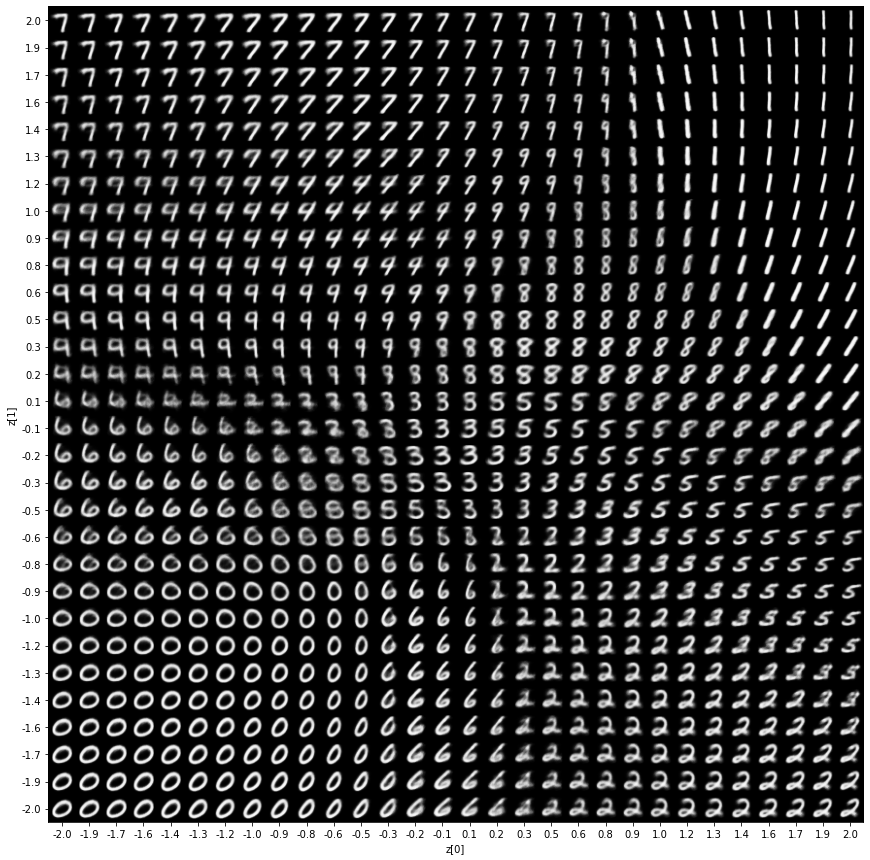

Output with scale 5:


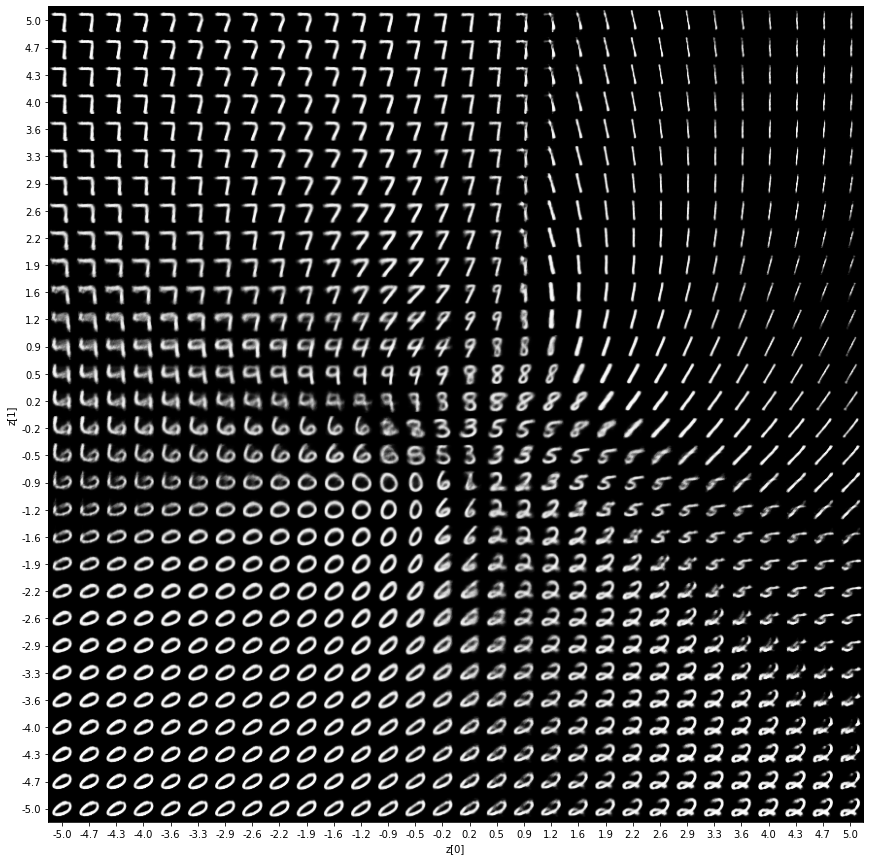

Output with scale 10:


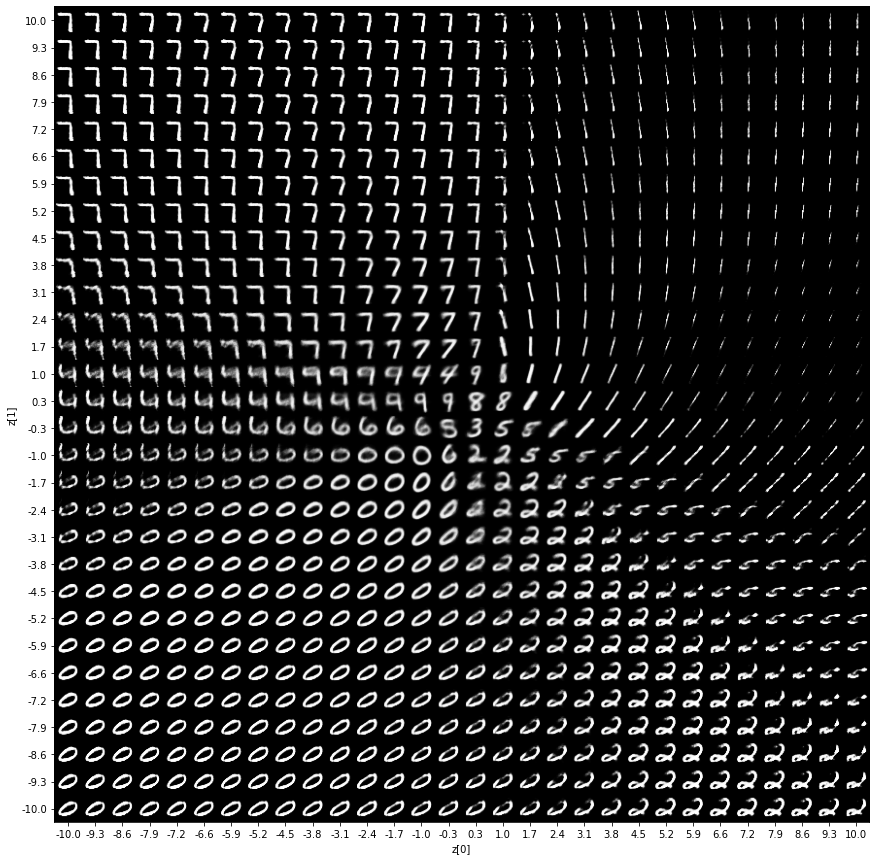

Output with scale 50:


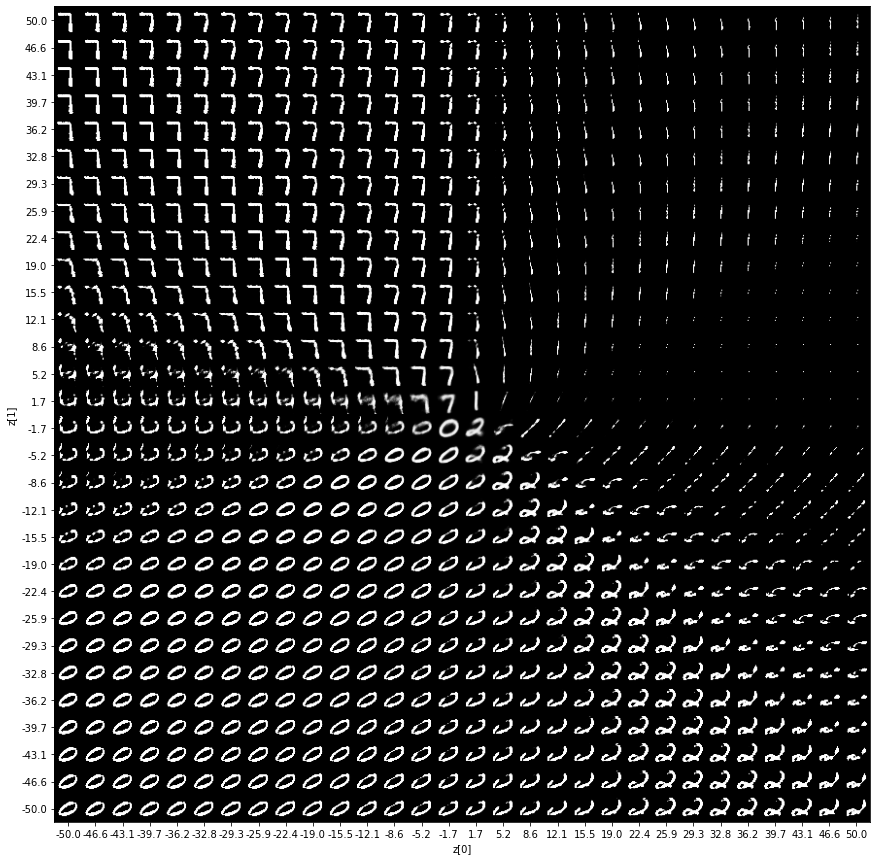

In [43]:
def plot_latent(encoder, decoder, scale=2.0, n = 30):
     
    digit_size = 28
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

scales = [2, 5, 10, 50]

for i in scales:
    print("Output with scale {}:".format(i))
    plot_latent(encoder, decoder, i, 30) 

#To complete: explore with different "scale"

This first plots are with the vae with layers : [500, 200, 50].

Loss obtained : 134.1262

How we can see here, the bigger the scale is, the more approximated the reconstruction results. For example, many nines results to be sevens, eights seems ones and fives results zeros. It seems like the points of the prevision are closer or more spreaded.

Let's finaly check how the different digits have been rapresented in the latent space by the VAE.

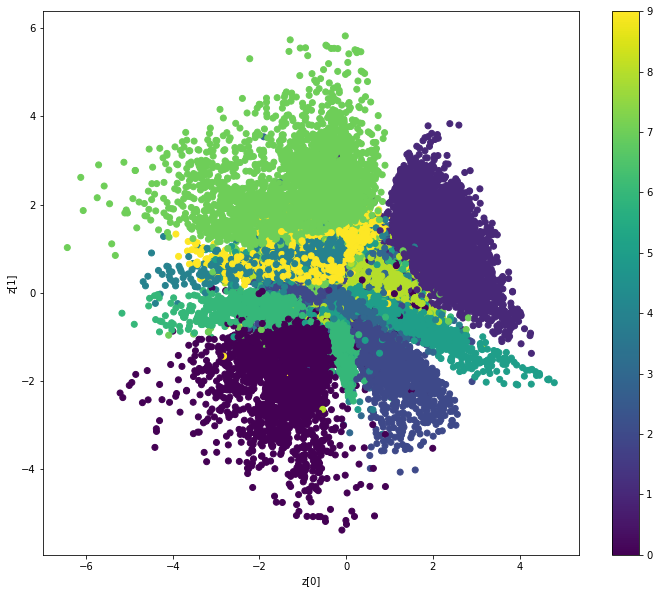

In [44]:
def plot_label_clusters(encoder, decoder, data, labels):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(encoder, decoder, x_train, y_train)

**To complete: Discuss the obtained plots, and  explore how the hyper-parameters of the VAE (number of layers, layer sizes, etc.) influence the final result.**

Results with layers sizes : [500, 200, 10]. 

Loss obtained : 135.7573.

Here, the latent space seems to be similar the previous one, but rotated. Some patterns are similar and for example, in the middle there is again much confusion in the middle and less in the sides. Number representation change much, in the sense that the space where number are represented changes much, but the final representation are a bit similar.

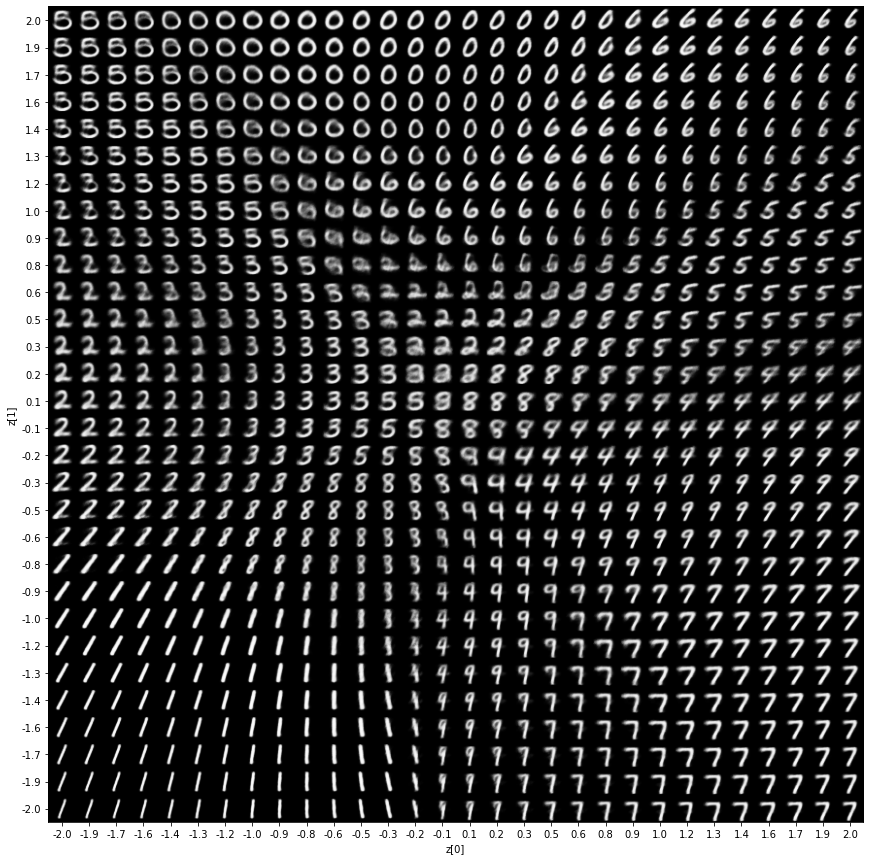

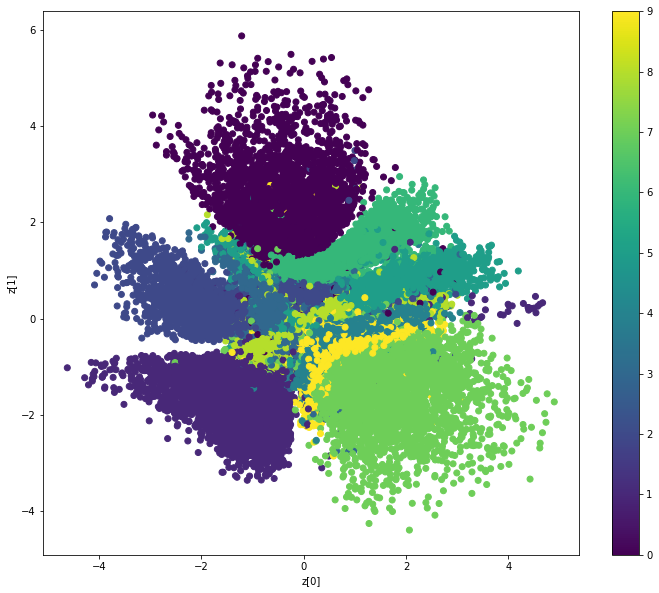

In [38]:
plot_latent(encoder, decoder, 2, 30) 
plot_label_clusters(encoder, decoder, x_train, y_train)

Results with layers sizes : [500, 200].

Loss obtained : 136.3375.


Here, the clusters are more confused in the middle and also the representations are less accurate than before. The loss obtained here in percentage is not so far, but the results are much differents.

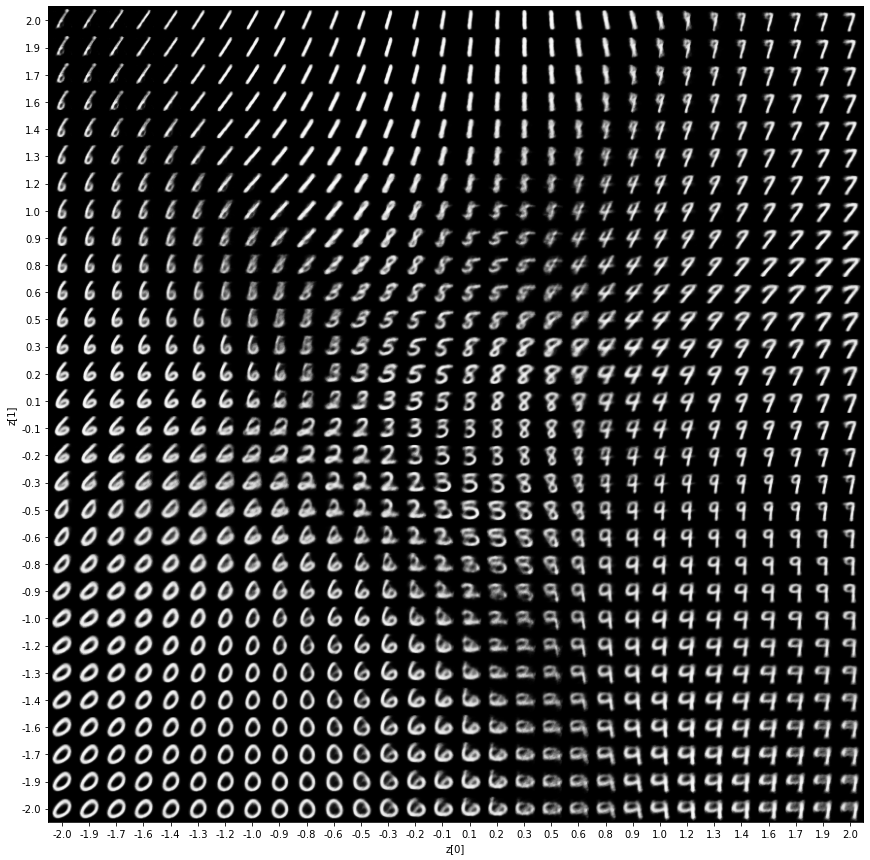

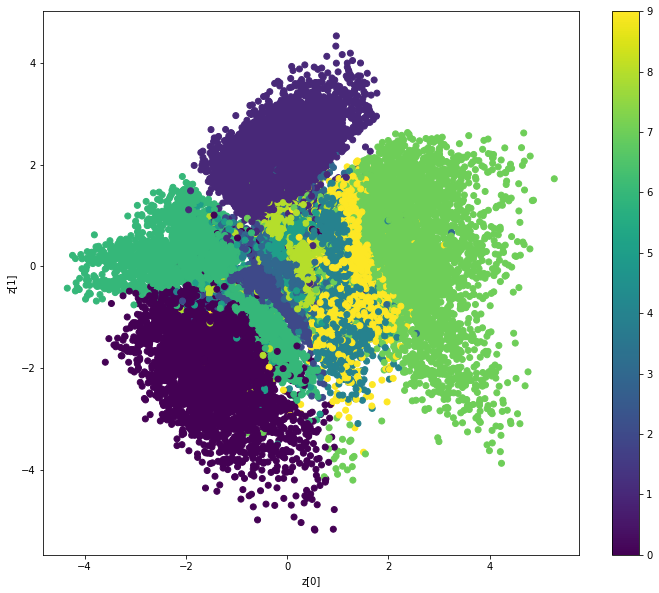

In [23]:
plot_latent(encoder, decoder, 2, 30) 
plot_label_clusters(encoder, decoder, x_train, y_train)

Results with layers : [500, 200, 50] and activation function sigmoid.

Loss obtained : 154.5063.

Here, the latent space seems to represent columns and is not nice, because points are spreaded over it. Also by looking the representations we can see how it can't separate different representation in the same x axis region.

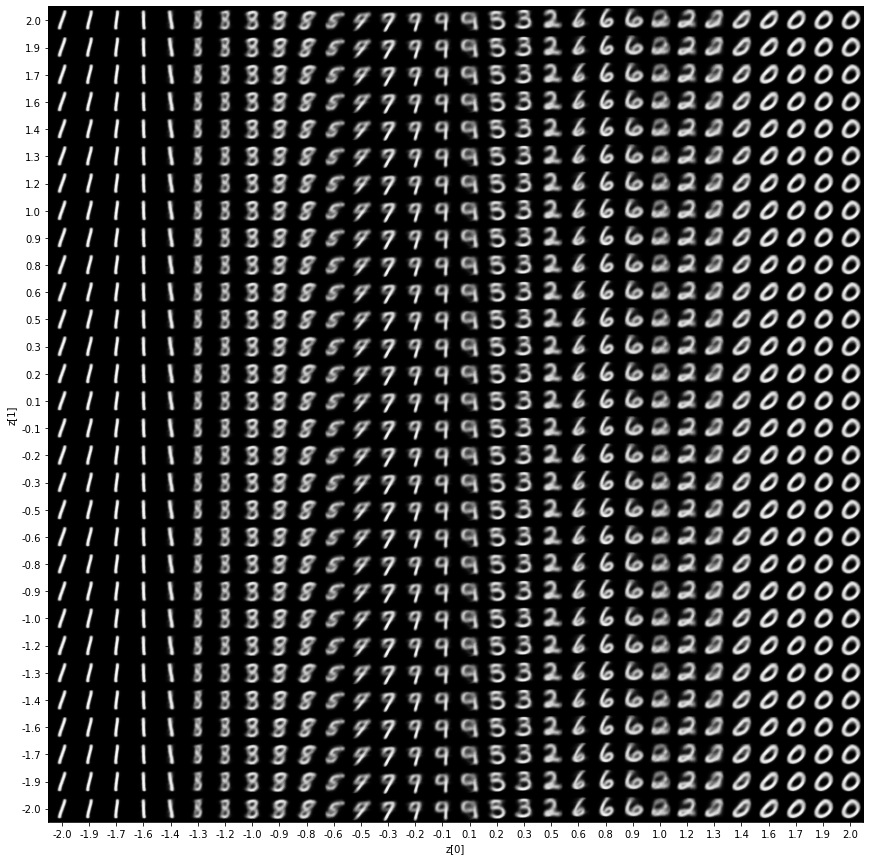

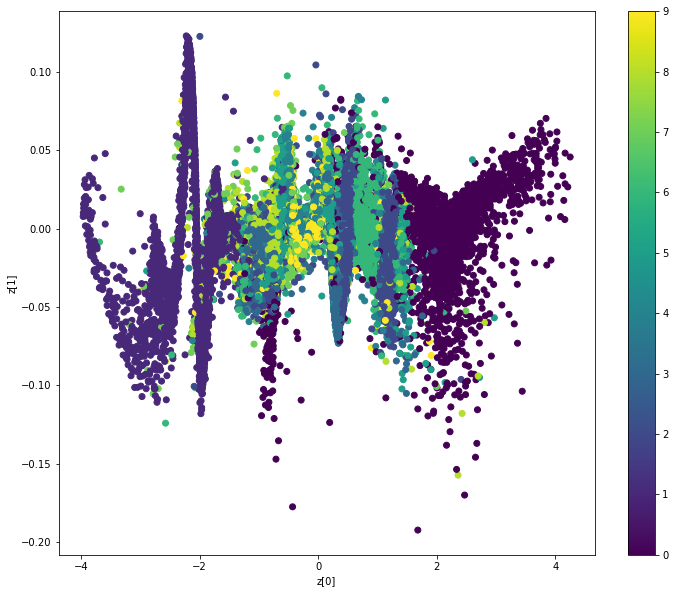

In [28]:
plot_latent(encoder, decoder, 2, 30) 
plot_label_clusters(encoder, decoder, x_train, y_train)

VAE with only 1 layer of size : [200].

Loss obtained :  148.1035.

Here, the VAE can represent only 4 clusters well (0,6,8,9) and we can see it also in the representation plot, where other numbers don't appear.

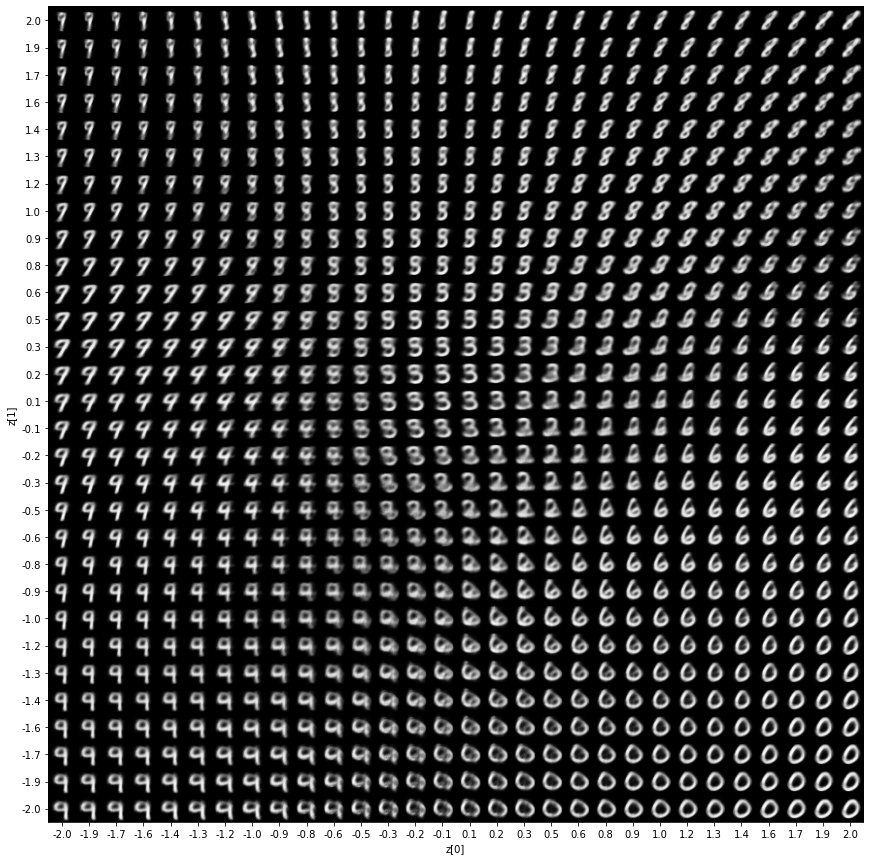

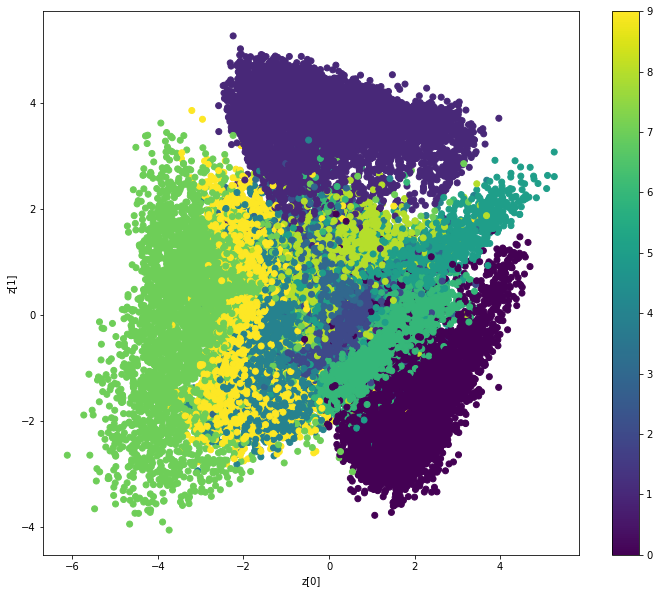

In [33]:
plot_latent(encoder, decoder, 2, 30) 
plot_label_clusters(encoder, decoder, x_train, y_train)